In [1]:
import time
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils
import select_copula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
path = '/home/nina/VRData/Processing/pkls'

n1 = 5
n2 = 14

X,Y = utils.load_experimental_data(path, animal, day_name, n1, n2)
exp_pref = '{}_{}'.format(animal,day_name)

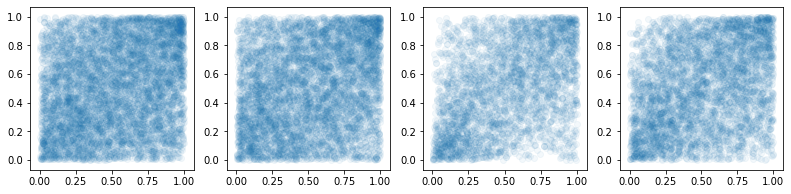

In [3]:
fig, ax = plt.subplots(1,4,figsize=(13.5,3))
ax[0].scatter(*Y[X[:,0]<6/16].T,alpha=0.05)
ax[1].scatter(*Y[(X[:,0]>=6/16) & (X[:,0]<12/16)].T,alpha=0.05)
ax[2].scatter(*Y[(X[:,0]>=12/16) & (X[:,0]<14/16)].T,alpha=0.05)
ax[3].scatter(*Y[(X[:,0]>=14/16) & (X[:,0]<1)].T,alpha=0.05)

In [ ]:
%time (model, waic) = select_copula.select_copula_model(X,Y,1,exp_pref,'./imgs',n1,n2)

In [ ]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()